これによると需要予測ができるぽい

http://www.itmedia.co.jp/business/articles/1702/17/news125.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['font.family'] = 'AppleGothic'

In [2]:
df_train = pd.read_csv("../data_raw/train.csv")
df_train.tail()

,id,y,year,stage,match,gameday,time,home,away,stadium,tv
1716,16233,3756,2014,Ｊ２,第２４節第１日,07/30(水),19:04,カターレ富山,愛媛ＦＣ,富山県総合運動公園陸上競技場,スカパー！／スカパー！プレミアムサービス
1717,16234,7842,2014,Ｊ２,第２４節第１日,07/30(水),19:04,ジュビロ磐田,カマタマーレ讃岐,ヤマハスタジアム（磐田）,スカパー！／スカパー！プレミアムサービス
1718,16235,5212,2014,Ｊ２,第２４節第１日,07/30(水),19:04,ＦＣ岐阜,ファジアーノ岡山,岐阜メモリアルセンター長良川競技場,スカパー！／スカパー！プレミアムサービス
1719,16236,3883,2014,Ｊ２,第２４節第１日,07/30(水),19:03,アビスパ福岡,湘南ベルマーレ,レベルファイブスタジアム,スカパー！／スカパー！プレミアムサービス
1720,16237,5028,2014,Ｊ２,第２４節第１日,07/30(水),19:03,大分トリニータ,栃木ＳＣ,大分銀行ドーム,スカパー！／スカパー！プレミアムサービス


## スタジアム別平均入場者数

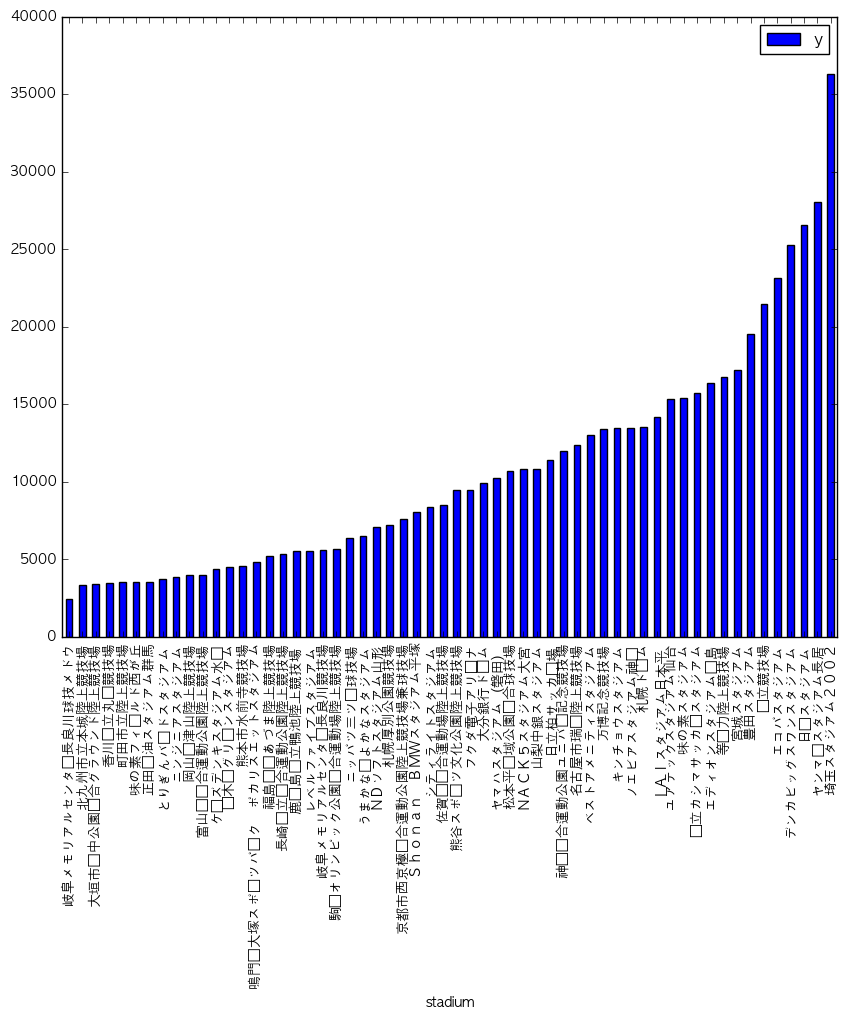

In [3]:
df_train.groupby('stadium')['y'].mean().to_frame().sort_values(by='y').plot.bar(figsize=(10, 8))

In [4]:
avg_cus = []
for stadium, group in df_train.groupby('stadium')['y']:
    avg_cus.append([stadium, np.mean(group)])
df_avg_cus = pd.DataFrame(avg_cus, columns=['stadium', 'avg_cus'])
df_train = pd.merge(df_train, df_avg_cus, on='stadium')

## 曜日

In [5]:
# 曜日だけ取り出す
df_train['youbi'] = df_train['gameday'].apply(lambda g: g.split('(')[1].replace(')', '').replace('祝','').replace('休','').replace('・', ''))

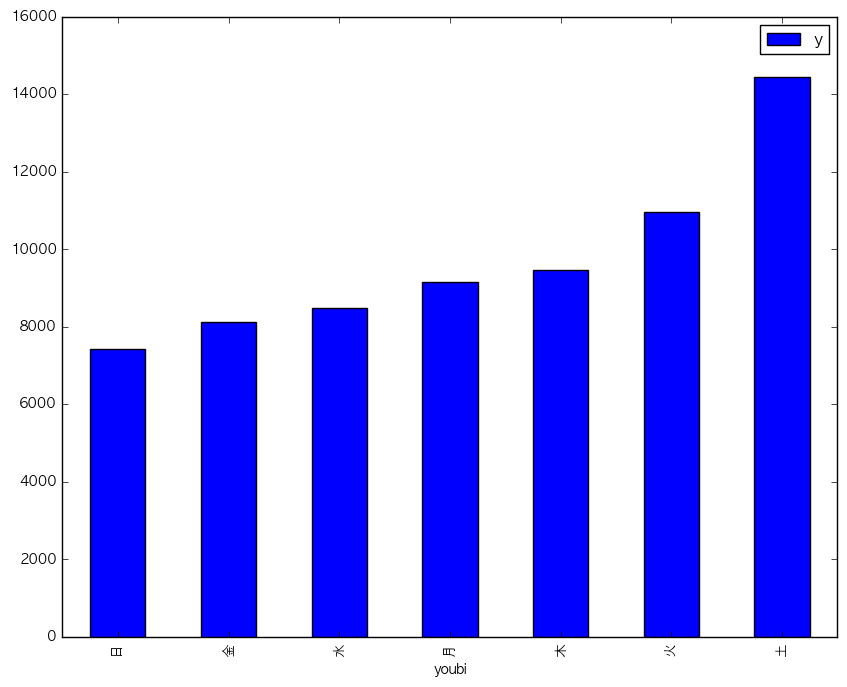

In [6]:
# 曜日別の観客動員数平均
df_train.groupby('youbi')['y'].mean().to_frame().sort_values(by='y').plot.bar(figsize=(10, 8))

## 節

In [7]:
# 節だけ取り出す
df_train['setsu'] = df_train['match'].apply(lambda m: int(m.split('節')[0].replace('第','')))

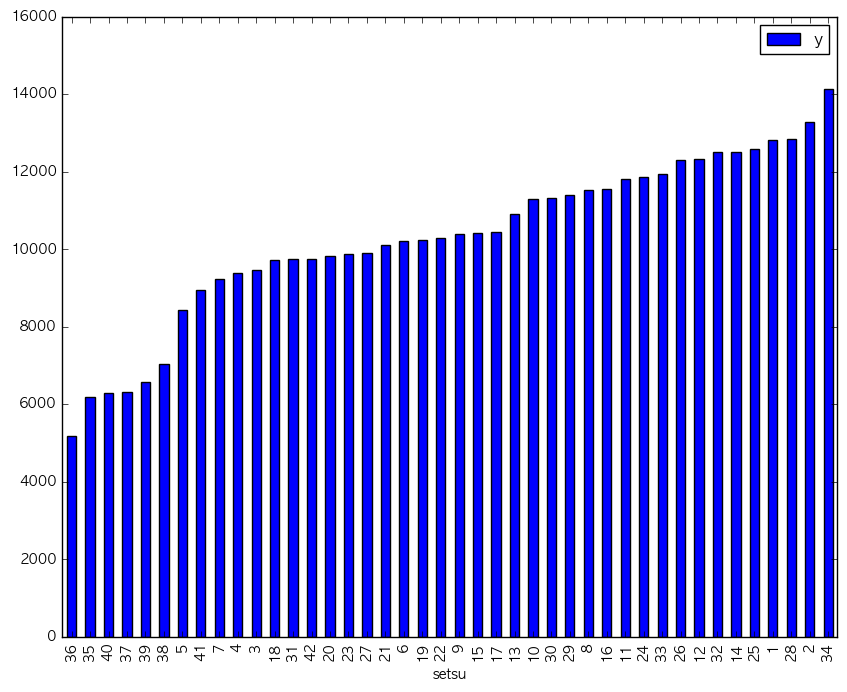

In [8]:
# 節別の観客動員数平均
df_train.groupby('setsu')['y'].mean().to_frame().sort_values(by='y').plot.bar(figsize=(10, 8))

## 開始時間

In [9]:
# 節だけ取り出す
df_train['start_hour'] = df_train['time'].apply(lambda m: int(m.split(':')[0]))

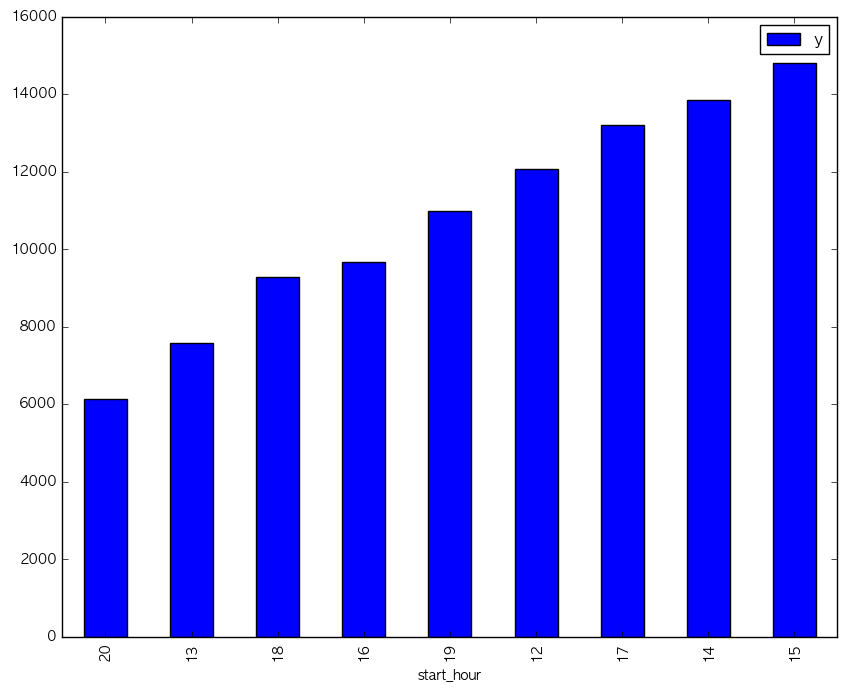

In [10]:
# 開始時間別の観客動員数平均
df_train.groupby('start_hour')['y'].mean().to_frame().sort_values(by='y').plot.bar(figsize=(10, 8))

## データをCSVに書き出す

In [11]:
df_train.head(3)

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,avg_cus,youbi,setsu,start_hour
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,15351.315789,土,1,14
1,14012,11831,2012,Ｊ１,第３節第１日,03/24(土),13:03,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）,15351.315789,土,3,13
2,14031,13147,2012,Ｊ１,第５節第１日,04/07(土),14:03,ベガルタ仙台,ジュビロ磐田,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ仙台／ＮＨＫ静岡,15351.315789,土,5,14


In [12]:
df_train.to_csv('../data/input_train_data.csv')

## カテゴリデータを数値にする

In [13]:
# 曜日
youbi_mapping = { '月': 0, '火': 1, '水': 2, '木': 3, '金': 4, '土': 5, '日': 6 }
df_train['youbi_val'] = df_train['youbi'].map(youbi_mapping).astype(int)

## トレーニングデータを用意する

In [14]:
x_train = df_train[['avg_cus', 'start_hour', 'youbi_val', 'setsu']].values
y_train = df_train['y'].values
x_train.shape, y_train.shape

((1721, 4), (1721,))

## 重回帰分析に入れて予測してみる

In [15]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_train)

/Users/yanagi/.pyenv/versions/3.5.1/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


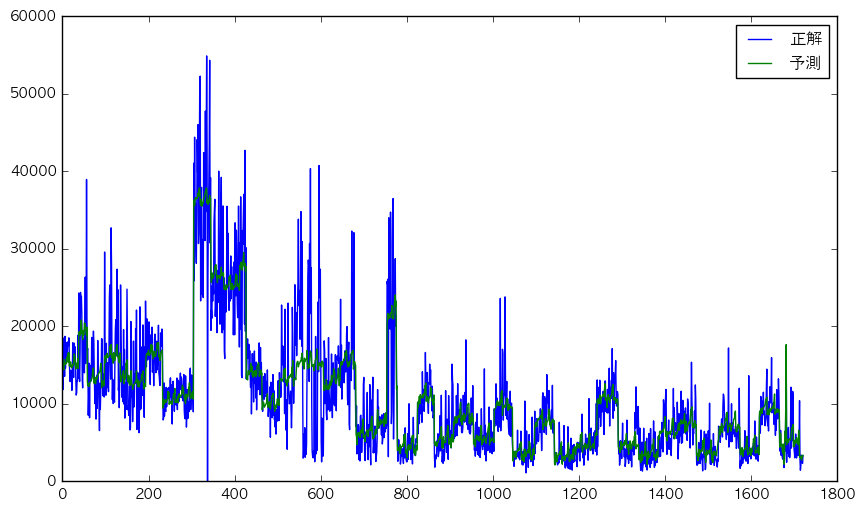

In [18]:
plt.figure(figsize=(10, 6))
xlin = np.arange(0, len(y_train))
plt.plot(xlin, y_train, label='正解')
plt.plot(xlin, y_pred, label='予測')
plt.legend()
plt.show()

/Users/yanagi/.pyenv/versions/3.5.1/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


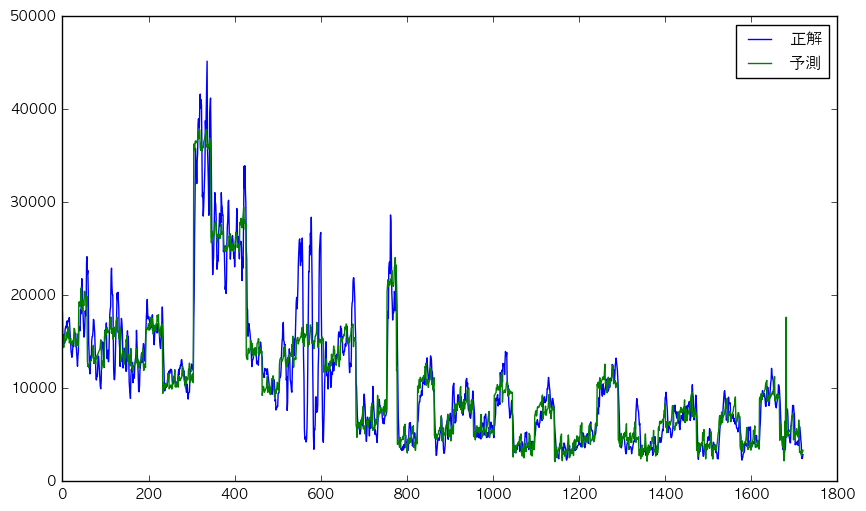

In [21]:
# 正解ぶれすぎるので移動平均にしてみる
plt.figure(figsize=(10, 6))
plt.plot(xlin, pd.rolling_mean(y_train, 5, 1), label='正解')
plt.plot(xlin, y_pred, label='予測')
plt.legend()
plt.show()

## 説明変数の確認

参考: http://pythondatascience.plavox.info/scikit-learn/%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0

In [25]:
# 'avg_cus', 'start_hour', 'youbi_val', 'setsu'

print('偏回帰係数:', lr.coef_)
print('切片:', lr.intercept_)

偏回帰係数: [   1.01635862 -161.94988994   97.42113719   54.16781385]
切片: 1009.76737518


$
観客動員数 = スタジアムの平均観客動員数 * 1.01 + 開始時刻 * -161 + 曜日 * 97 + 節 * 54 + 1009
$

In [27]:
def f(avg_cus, start_hour, youbi_val, setsu):
    return avg_cus*1.016 + start_hour*-161.94 + youbi_val*97 + setsu*54.16 + 1009.76

In [38]:
# 移動平均だと結構予測できそうだけど、、、
for i in range(0, 5):
    avg_cus, start_hour, youbi_val, setsu = x_train[i]
    y = pd.rolling_mean(y_train, 5, 1)[i]
    y_pred = f(avg_cus, start_hour, youbi_val, setsu)
    print('index:', i, 'y=', y, 'y_pred=', y_pred)

index: 0 y= 18250.0 y_pred= 14878.6968421
index: 1 y= 15040.5 y_pred= 15148.9568421
index: 2 y= 14409.3333333 y_pred= 15095.3368421
index: 3 y= 15105.0 y_pred= 14393.9568421
index: 4 y= 15789.0 y_pred= 15625.0768421


/Users/yanagi/.pyenv/versions/3.5.1/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()
